### Training a Pothole detector using RCNN

The complete process

1. Load the data using the annotation CSV file

2. Prepare the train and test sets

3. Create the classifier using  MobilenetV2 applying transfer learning

4. Warming up the network and checking the metrics

5. Unfreezing part of the network and then verifying the network

6. RCNN proposals using OpenCV and detection of bounding boxes with Keras

7. Building the bounding boxes and applying non maxima suppression in the Inference cycle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import pandas as pd
import io
import cv2
import h5py
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import extract_patches_2d
from imutils import paths
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model
import imutils

In [ ]:
# Reading the csv file
pothole_df = pd.read_csv('/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/pothole_df.csv')


In [ ]:
pothole_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,pothole1.jpeg,275,183,pothole,64,78,130,107
1,pothole1.jpeg,275,183,pothole,44,105,131,154
2,pothole1.jpeg,275,183,pothole,12,151,59,177
3,pothole1.jpeg,275,183,vegetation,163,33,254,58
4,pothole1.jpeg,275,183,pothole,115,54,142,74


In [ ]:
# Empty lists to store data and labels
data = []
labels = []

In [ ]:
# Functions to extract the bounding boxes and preprocess the image
def roiExtractor(row,path):
    img = cv2.imread(path + row['filename'])    
    # Get the bounding box elements
    bb = [int(row['xmin']),int(row['ymin']),int(row['xmax']),int(row['ymax'])]
    # Crop the image
    roi = img[bb[1]:bb[3], bb[0]:bb[2]]
    # Reshape the image
    roi = cv2.resize(roi,(224,224),interpolation=cv2.INTER_CUBIC)
    #print(roi.shape)
    # Convert the image to an array
    roi = img_to_array(roi)
    # Preprocess the image
    roi = preprocess_input(roi)    
    return roi

In [ ]:
# This is the path where the images are placed. Change this path to the location you have defined
path = '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/'
# Looping through the excel sheet rows
for idx, row in pothole_df.iterrows():    
    if row['class'] == 'pothole':
        roi = roiExtractor(row,path)
        # Append the data and labels for the positive class
        data.append(roi)
        labels.append(int(1))

In [ ]:
print(len(data))
print(data[0].shape)

31
(224, 224, 3)


In [ ]:
# Listing all the negative examples
path = '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/negative'
roadFiles = glob.glob(path + '/*.jpeg')
print(len(roadFiles))

21


In [ ]:
# Looping through the images of negative class
for row in roadFiles:
    # Read the image
    img = cv2.imread(row)
    # Extract patches
    patches = extract_patches_2d(img,(128,128),max_patches=2)
    # For each patch do the augmentation
    for patch in patches:        
        # Reshape the image
        roi = cv2.resize(patch,(224,224),interpolation=cv2.INTER_CUBIC)
        #print(roi.shape)
        # Convert the image to an array
        roi = img_to_array(roi)
        # Preprocess the image
        roi = preprocess_input(roi)
        #print(roi.shape)
        # Append the data into the data folder and labels folder
        data.append(roi)
        labels.append(int(0))        

In [ ]:
print(len(data))
print(len(labels))

73
73


In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
print(data.shape)
print(labels.shape)

(73, 224, 224, 3)
(73,)


In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
# Fit transform the labels array
labels = lb.fit_transform(labels)
# Convert this to categorical 
labels = to_categorical(labels)
print(labels.shape)


(73, 2)


In [ ]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [ ]:
# Partition data to train and test set with 85 : 15 split
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.15, stratify=labels, random_state=42)
print("training data shape :",trainX.shape)
print("testing data shape :",testX.shape)
print("training labels shape :",trainY.shape)
print("testing labels shape :",testY.shape)

training data shape : (62, 224, 224, 3)
testing data shape : (11, 224, 224, 3)
training labels shape : (62, 2)
testing labels shape : (11, 2)


In [ ]:
# Create the base network by removing the top of the MobileNetV2 model
baseNetwork = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# Create a custom head network on top of the basenetwork to cater to two classes.
topNetwork = baseNetwork.output
topNetwork = AveragePooling2D(pool_size=(5, 5))(topNetwork)
topNetwork = Flatten(name="flatten")(topNetwork)
topNetwork = Dense(128, activation="relu")(topNetwork)
topNetwork = Dropout(0.5)(topNetwork)
topNetwork = Dense(2, activation="softmax")(topNetwork)
# Place our custom top layer on top of the base layer. We will only train the base layer.
model = Model(inputs=baseNetwork.input, outputs=topNetwork)
# Freeze the base network so that they are not updated during the training process
for layer in baseNetwork.layers:
    layer.trainable = False

In [ ]:
# Initialise the learning rate, epochs and batch size
LR = 1e-4
epoc = 5
bs = 16

In [ ]:
# Create a image generator with data augmentation
aug = ImageDataGenerator(rotation_range=40,zoom_range=0.25,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.30,
 horizontal_flip=True,fill_mode="nearest")

#### Warm Up Training

Let us warm up the top layer after making all the layers as non-trainable

In [ ]:
# Compile the model
print("[INFO] compiling model...")
opt = Adam(lr=LR)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# Training the customer head network
print("[INFO] training the model...")
history = model.fit(aug.flow(trainX, trainY, batch_size=bs),steps_per_epoch=len(trainX) // bs,validation_data=(testX, testY),
 validation_steps=len(testX) // bs,epochs=epoc)

[INFO] compiling model...
[INFO] training the model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
3/3 [==============================] - 5s 624ms/step - loss: 1.0718 - accuracy: 0.5870
Epoch 2/5
3/3 [==============================] - 2s 528ms/step - loss: 0.8924 - accuracy: 0.5652
Epoch 3/5
3/3 [==============================] - 2s 590ms/step - loss: 0.8128 - accuracy: 0.5417
Epoch 4/5
3/3 [==============================] - 2s 598ms/step - loss: 0.7464 - accuracy: 0.6957
Epoch 5/5
3/3 [==============================] - 2s 594ms/step - loss: 0.6574 - accuracy: 0.6957


In [ ]:
# Converting the target names as string for classification report
target_names = list(map(str,lb.classes_))

In [ ]:
# make predictions on the test set
print("[INFO] Generating inference...")
predictions = model.predict(testX, batch_size=bs)
# For each prediction we need to find the index with maximum probability 
predIdxs = np.argmax(predictions, axis=1)
# Print the classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=target_names))

[INFO] Generating inference...
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.60      0.75         5

    accuracy                           0.82        11
   macro avg       0.88      0.80      0.80        11
weighted avg       0.86      0.82      0.81        11



#### Layer training

After warming up the top layer, let us also make some of the existing layers trainable and observe the metrics

To do that let us first print out all the layers of the network

In [ ]:
for (i,layer) in enumerate(baseNetwork.layers):
    print(" [INFO] {}\t{}".format(i,layer.__class__.__name__))

 [INFO] 0	InputLayer
 [INFO] 1	Conv2D
 [INFO] 2	BatchNormalization
 [INFO] 3	ReLU
 [INFO] 4	DepthwiseConv2D
 [INFO] 5	BatchNormalization
 [INFO] 6	ReLU
 [INFO] 7	Conv2D
 [INFO] 8	BatchNormalization
 [INFO] 9	Conv2D
 [INFO] 10	BatchNormalization
 [INFO] 11	ReLU
 [INFO] 12	ZeroPadding2D
 [INFO] 13	DepthwiseConv2D
 [INFO] 14	BatchNormalization
 [INFO] 15	ReLU
 [INFO] 16	Conv2D
 [INFO] 17	BatchNormalization
 [INFO] 18	Conv2D
 [INFO] 19	BatchNormalization
 [INFO] 20	ReLU
 [INFO] 21	DepthwiseConv2D
 [INFO] 22	BatchNormalization
 [INFO] 23	ReLU
 [INFO] 24	Conv2D
 [INFO] 25	BatchNormalization
 [INFO] 26	Add
 [INFO] 27	Conv2D
 [INFO] 28	BatchNormalization
 [INFO] 29	ReLU
 [INFO] 30	ZeroPadding2D
 [INFO] 31	DepthwiseConv2D
 [INFO] 32	BatchNormalization
 [INFO] 33	ReLU
 [INFO] 34	Conv2D
 [INFO] 35	BatchNormalization
 [INFO] 36	Conv2D
 [INFO] 37	BatchNormalization
 [INFO] 38	ReLU
 [INFO] 39	DepthwiseConv2D
 [INFO] 40	BatchNormalization
 [INFO] 41	ReLU
 [INFO] 42	Conv2D
 [INFO] 43	BatchNormalizatio

In [ ]:
for layer in baseNetwork.layers[140:]:
    layer.trainable = True

# Compile the model
print("[INFO] Compiling the model again...")
opt = Adam(lr=LR)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# Training the customer head network
print("[INFO] Fine tuning the model along with some layers of base network...")
history = model.fit(aug.flow(trainX, trainY, batch_size=bs),steps_per_epoch=len(trainX) // bs,validation_data=(testX, testY),
 validation_steps=len(testX) // bs,epochs=epoc)

[INFO] Compiling the model again...
[INFO] Fine tuning the model along with some layers of base network...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
3/3 [==============================] - 5s 739ms/step - loss: 0.5943 - accuracy: 0.7500
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 0.4653 - accuracy: 0.7609
Epoch 3/5
3/3 [==============================] - 2s 748ms/step - loss: 0.3108 - accuracy: 0.9565
Epoch 4/5
3/3 [==============================] - 2s 646ms/step - loss: 0.3229 - accuracy: 0.8478
Epoch 5/5
3/3 [==============================] - 2s 703ms/step - loss: 0.1494 - accuracy: 1.0000


In [ ]:
# make predictions on the test set
print("[INFO] Generating inference...")
predictions = model.predict(testX, batch_size=bs)
# For each prediction we need to find the index with maximum probability 
predIdxs = np.argmax(predictions, axis=1)
# Print the classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=target_names))

[INFO] Generating inference...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



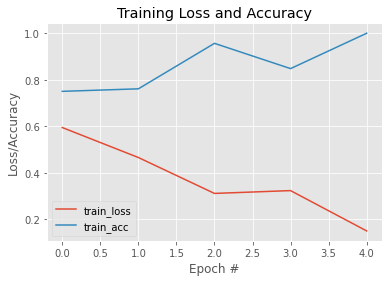

In [ ]:
# plot the training loss and accuracy
N = epoc
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.savefig("plot.png")
plt.show()

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/output/pothole_detector_RCNN.h5"
ENCODER_PATH = "/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/output/label_encoder_RCNN.pickle"
# serialize the model to disk
print("[INFO] saving pothole detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving pothole detector model...
[INFO] saving label encoder...


#### Inference Cycle

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/output/pothole_detector_RCNN.h5"
ENCODER_PATH = "/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/output/label_encoder_RCNN.pickle"
print("[INFO] loading model and label binarizer...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(ENCODER_PATH, "rb").read())

[INFO] loading model and label binarizer...


In [ ]:
# Please change the path where your files are placed
testpath = '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/test'
testFiles = glob.glob(testpath + '/*.jpeg')
testFiles

['/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/test/images1.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/test/images2.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/test/images3.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/test/images4.jpeg',
 '/content/drive/MyDrive/Bayesian Quest/JMJTL-BQ-ObjectDetection/data/test/images5.jpeg']

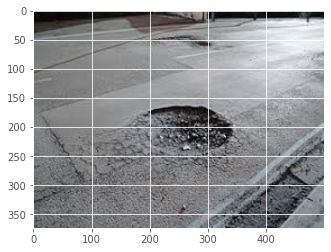

In [ ]:
# load the input image from disk
image = cv2.imread(testFiles[2])
#Resize the image and plot the image
image = imutils.resize(image, width=500)
plt.imshow(image,aspect='equal')
plt.show()

In [ ]:
# Implementing selective search to generate bounding box proposals
print("[INFO] running selective search and generating bounding boxes...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

[INFO] running selective search and generating bounding boxes...


In [ ]:
len(rects)

915

In [ ]:
# Initialise lists to store the region of interest from the image and its bounding boxes
proposals = []
boxes = []
#max_proposals = 100
# Iterate over the bounding box coordinates to extract region of interest from image
for (x, y, w, h) in rects:    
    # Crop region of interest from the image
	roi = image[y:y + h, x:x + w]
    # Convert to RGB format as CV2 has output in BGR format
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    # Resize image to our standar size
	roi = cv2.resize(roi, (224,224),
		interpolation=cv2.INTER_CUBIC)
	# Preprocess the image
	roi = img_to_array(roi)
	roi = preprocess_input(roi)
	# Update the proposal and bounding boxes
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

In [ ]:
# Convert proposals and bouding boxes to NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))
# Classify the proposals based on the fine tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals)

[INFO] proposal shape: (915, 224, 224, 3)
[INFO] classifying proposals...


In [ ]:
# Find the predicted labels 
labels = lb.classes_[np.argmax(proba, axis=1)]
# Get the ids where the predictions are 'Potholes'
idxs = np.where(labels == 1)[0]
idxs

array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  27,
        28,  29,  30,  31,  32,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  61,  62,  63,  64,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 18

In [ ]:
# Using the indexes extract the bounding boxes and prediction probabilities
boxes = boxes[idxs]
proba = proba[idxs][:, 1]

In [ ]:
proba

array([0.998042  , 0.9974941 , 0.9984456 , 0.9999901 , 0.9982687 ,
       0.99892455, 0.9975541 , 0.9977992 , 0.9998442 , 0.9999995 ,
       0.9995098 , 0.99562496, 0.9994154 , 0.9996916 , 0.9973214 ,
       0.99988806, 0.9976234 , 0.99792284, 0.99846363, 0.99780566,
       0.99580634, 0.99781656, 0.9995448 , 0.9972257 , 0.99890065,
       0.9961915 , 0.9998385 , 0.9996464 , 0.9982052 , 0.9992507 ,
       0.9960674 , 0.99981755, 0.99806076, 0.9970065 , 0.99944955,
       0.9995834 , 0.9996538 , 0.9981505 , 0.99998724, 0.9979963 ,
       0.9991381 , 0.9993025 , 0.99916625, 0.997274  , 0.9976088 ,
       0.9986822 , 0.99538887, 0.9997203 , 0.99984145, 0.9990257 ,
       0.99786854, 0.99960405, 0.9957852 , 0.99971944, 0.99983966,
       0.99632734, 0.9997931 , 0.99824786, 0.9998223 , 0.9969694 ,
       0.9991167 , 0.9999896 , 0.9998431 , 0.9985043 , 0.9981998 ,
       0.99745375, 0.99949884, 0.99965584, 0.9964055 , 0.9972029 ,
       0.99798906, 0.996983  , 0.9999757 , 0.99853194, 0.99972

In [ ]:
print(len(boxes))
# Filter the bounding boxes using a prediction probability threshold
pred_threshold = 0.995
# Select only those ids where the probability is greater than the threshold
idxs = np.where(proba >= pred_threshold)
boxes = boxes[idxs]
proba = proba[idxs]
print(len(boxes))

845
395


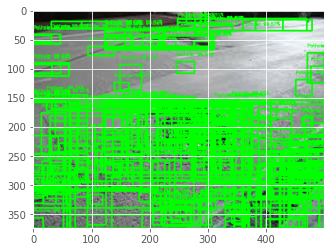

In [ ]:
# Clone the original image for visualisation and inserting text
clone = image.copy()
# Iterate through the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
    # Draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = box
    cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
    # Initialising the cordinate for writing the text
    y = startY - 10 if startY - 10 > 10 else startY + 10
    # Getting the text to be attached on top of the box
    text= "Pothole: {:.2f}%".format(prob * 100)
    # Visualise the text on the image
    cv2.putText(clone, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 255, 0), 1)
# Visualise the bounding boxes on the image
plt.imshow(clone,aspect='equal')
plt.show() 

In [ ]:
def maxOverlap(boxes):
    '''
    boxes : This is the cordinates of the boxes which have the object
    returns : A list of boxes which do not have much overlap
    '''
    # Convert the bounding boxes into an array
    boxes = np.array(boxes)
    # Initialise a box to pick the ids of the selected boxes and include the largest box
    selected = []
    # Continue the loop till the number of ids remaining in the box is greater than 1
    while len(boxes) > 1:
        # First calculate the area of the bounding boxes 
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        area = (x2 - x1) * (y2 - y1)
        # Sort the bounding boxes based on its area    
        ids = np.argsort(area)
        #print('ids',ids)
        # Take the coordinates of the box with the largest area
        lx1 = boxes[ids[-1], 0]
        ly1 = boxes[ids[-1], 1]
        lx2 = boxes[ids[-1], 2]
        ly2 = boxes[ids[-1], 3]
        # Include the largest box into the selected list
        selected.append(boxes[ids[-1]].tolist())
        # Initialise a list for getting those ids that needs to be removed.
        remove = []
        remove.append(ids[-1])
        # We loop through each of the other boxes and find the overlap of the boxes with the largest box
        for id in ids[:-1]:
            #print('id',id)
            # The maximum of the starting x cordinate is where the overlap along width starts
            ox1 = np.maximum(lx1, boxes[id,0])
            # The maximum of the starting y cordinate is where the overlap along height starts
            oy1 = np.maximum(ly1, boxes[id,1])
            # The minimum of the ending x cordinate is where the overlap along width ends
            ox2 = np.minimum(lx2, boxes[id,2])
            # The minimum of the ending y cordinate is where the overlap along height ends
            oy2 = np.minimum(ly2, boxes[id,3])
            # Find area of the overlapping coordinates
            oa = (ox2 - ox1) * (oy2 - oy1)
            # Find the ratio of overlapping area of the smaller box with respect to its original area
            olRatio = oa/area[id]            
            # If the overlap is greater than threshold include the id in the remove list
            if olRatio > 0.40:
                remove.append(id)                
        # Remove those ids from the original boxes
        boxes = np.delete(boxes, remove,axis = 0)
        # Break the while loop if nothing to remove
        if len(remove) == 0:
            break
    # Append the remaining boxes to the selected
    for i in range(len(boxes)):
        selected.append(boxes[i].tolist())
    return np.array(selected)

In [ ]:
len(boxes)

395

In [ ]:
# Applying non maxima suppression
selected = maxOverlap(boxes)
len(selected)

5

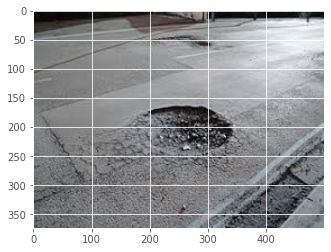

In [ ]:
clone = image.copy()
plt.imshow(image,aspect='equal')
plt.show()

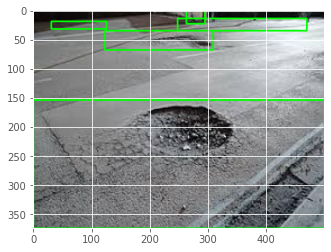

In [ ]:
for (startX, startY, endX, endY) in selected:
    cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)       

plt.imshow(clone,aspect='equal')
plt.show() 